## This project will make use of the Foursquare API in order to cluster the stations of London based on the types of Arts & Entertainments venues that are near them

In [298]:
# importing necessary libraries
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import json
import requests

import folium # library for visualising maps

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

from geopy.geocoders import Nominatim
print('Libraries imported!')

Libraries imported!


### Creating pandas DataFrame using available station data

In [299]:
url = 'https://www.doogal.co.uk/LondonStationsCSV.ashx'
stations = pd.read_csv(url)
stations.head()

,Station,OS X,OS Y,Latitude,Longitude,Zone,Postcode
0,Abbey Road,539081,183352,51.531952,0.003723,3,E15 3NB
1,Abbey Wood,547297,179002,51.490784,0.120272,4,SE2 9RH
2,Acton Central,520613,180299,51.508758,-0.263430,2,W3 6BH
3,Acton Main Line,520296,181196,51.516887,-0.267690,3,W3 9EH
4,Acton Town,519457,179639,51.503071,-0.280303,3,W3 8HN


In [300]:
# removing unecessary columns
stations.drop(['OS X','OS Y','Postcode'], axis=1, inplace=True)
stations.head()

,Station,Latitude,Longitude,Zone
0,Abbey Road,51.531952,0.003723,3
1,Abbey Wood,51.490784,0.120272,4
2,Acton Central,51.508758,-0.263430,2
3,Acton Main Line,51.516887,-0.267690,3
4,Acton Town,51.503071,-0.280303,3


In [302]:
# types of zones in the dataframe
stations['Zone'].unique()

array(['3', '4', '2', '3,4,5,6', '5', '1', '9', '2,3', '6', '3,4', '7',
       nan, '8', '1,2', '5,6', '6,7'], dtype=object)

In [303]:
# dropping every zone except for 1 and 2 for simplicity and because they are too far
indexes = stations[(stations['Zone'] != '1') & 
                   (stations['Zone'] != '2') & 
                   (stations['Zone'] != '1,2')].index

stations.drop(indexes, inplace=True)
stations.reset_index(drop=True, inplace=True)
stations.head()

,Station,Latitude,Longitude,Zone
0,Acton Central,51.508758,-0.263430,2
1,Aldgate,51.514342,-0.075627,1
2,Aldgate East,51.515082,-0.073001,1
3,All Saints,51.510477,-0.012625,2
4,Angel,51.532968,-0.105581,1


### Visualising the location of each station on a map

In [304]:
# getting the geographical coordinates of London in order to visualise the map
geolocator = Nominatim(user_agent="london_stations")
location = geolocator.geocode('London')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


In [305]:
# creating a map of London using the latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding markers to map
for lat, lng, station in zip(stations['Latitude'], stations['Longitude'], stations['Station']):
    label = folium.Popup(station, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_london)  
    
map_london

### Getting the venues for each station

In [306]:
# foursquare credentials and version
CLIENT_ID = 'QZQGZJMDEIONHQILWYK3VMOQBB0VIZUUDPOXRAHDFRWHZI10'
CLIENT_SECRET = 'LAH5U4D51I5QU2IR1T1SIC33D4IDBFEXGB4PN0F2WDC15KST'
VERSION = '20180605'
arts_entertainment_id = '4d4b7104d754a06370d81259' # only interested in arts & entertainment venues
radius = 500  # radius of 500 meters around each station
LIMIT = 100 # limit to the number of venues

In [308]:
def getNearbyVenues(names, latitudes, longitudes):
    
    """ 
    This function uses the name, latitude and longitude of a station and calls the Foursquare API.
    Then, it extracts the category, latitude and longitude of each venue from the json file.
    Finally, it returns a list contatining the station's values and each venue.
    """
    
    # function that extracts the category of the venue
    def get_category_type(row):
        categories_list = row['venue.categories']      
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create call to the API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng, 
                    radius, 
                    LIMIT,
                    arts_entertainment_id)
        
        # get the category, latitude and longitude values for each venue from the json file            
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
            results = json_normalize(results)
        
            dataframe_filtered = results.loc[:, ['venue.categories', 'venue.location.lat', 'venue.location.lng']]

            # filter the category for each row
            dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

            # clean column names by keeping only last term
            dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

            venues_list.append([(
                                name,
                                lat,
                                lng,
                                row['categories'],
                                row['lat'],
                                row['lng']) for index, row in dataframe_filtered.iterrows()])
        except:
            pass
    
    # create final list to return
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                      'Station Latitude', 
                      'Station Longitude', 
                      'Venue Category', 
                      'Venue Latitude', 
                      'Venue Longitude']

    return(nearby_venues)

In [146]:
# get the venues for each station
station_venues = getNearbyVenues(names=stations['Station'],
                                latitudes=stations['Latitude'],
                                longitudes=stations['Longitude']
                                )
station_venues.head()

,Station,Station Latitude,Station Longitude,Venue Category,Venue Latitude,Venue Longitude
0,Acton Central,51.508758,-0.263430,Mini Golf,51.508583,-0.260178
1,Acton Central,51.508758,-0.263430,Concert Hall,51.506390,-0.264620
2,Acton Central,51.508758,-0.263430,Concert Hall,51.511511,-0.264933
3,Acton Central,51.508758,-0.263430,Music Venue,51.506138,-0.260869
4,Aldgate,51.514342,-0.075627,Mini Golf,51.514202,-0.080383


### Removing stations that have less that four unique venue categories near them

In [158]:
stations_unique = pd.DataFrame(station_venues.groupby('Station')['Venue Category'].nunique())

to_remove = stations_unique.drop(stations_unique[stations_unique['Venue Category'] < 4].index).reset_index()
to_remove_list = to_remove['Station'].tolist()

station_venues = station_venues[station_venues['Station'].isin(to_remove_list)].reset_index()
station_venues.head()

,Station,Station Latitude,Station Longitude,Venue Category,Venue Latitude,Venue Longitude
4,Aldgate,51.514342,-0.075627,Mini Golf,51.514202,-0.080383
5,Aldgate,51.514342,-0.075627,Art Gallery,51.516050,-0.070241
6,Aldgate,51.514342,-0.075627,Movie Theater,51.513657,-0.069217
7,Aldgate,51.514342,-0.075627,Art Gallery,51.516455,-0.070071
8,Aldgate,51.514342,-0.075627,Art Gallery,51.518273,-0.076920


### Combining some categories for better clustering

In [193]:
station_venues.loc[df['Venue Category'].str.contains('Museum'), 'Venue Category'] = 'Museum'
station_venues.loc[df['Venue Category'].str.contains('Movie Theater'), 'Venue Category'] = 'Movie Theater'

station_venues.head()

,Station,Station Latitude,Station Longitude,Venue Category,Venue Latitude,Venue Longitude
4,Aldgate,51.514342,-0.075627,Mini Golf,51.514202,-0.080383
5,Aldgate,51.514342,-0.075627,Art Gallery,51.516050,-0.070241
6,Aldgate,51.514342,-0.075627,Movie Theater,51.513657,-0.069217
7,Aldgate,51.514342,-0.075627,Art Gallery,51.516455,-0.070071
8,Aldgate,51.514342,-0.075627,Art Gallery,51.518273,-0.076920


### The number of venues for each station. There is big disparity mostly due to the location of each station

In [309]:
# number of venues by neighbourhood
station_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue Category,Venue Latitude,Venue Longitude
Station,,,,,
Aldgate,10,10,10,10,10
Aldgate East,8,8,8,8,8
Angel,15,15,15,15,15
Baker Street,14,14,14,14,14
Bank,7,7,7,7,7
Barbican,20,20,20,20,20
Barons Court,9,9,9,9,9
Belsize Park,4,4,4,4,4
Bermondsey,5,5,5,5,5


### Performing One Hot Encoding since there are only categorical values

In [195]:
# one hot encoding
stations_onehot = pd.get_dummies(station_venues[['Venue Category']], prefix="", prefix_sep="")

# add station column back to dataframe
stations_onehot['Station'] = station_venues['Station'] 

# move neighborhood column to the first column
fixed_columns = [stations_onehot.columns[-1]] + list(stations_onehot.columns[:-1])
stations_onehot = stations_onehot[fixed_columns]

stations_onehot.head()

,Station,Art Gallery,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Exhibit,Go Kart Track,Indie Theater,...,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Planetarium,Public Art,Rock Club,Street Art,Theater,Tour Provider,Zoo Exhibit
4,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Aldgate,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Aldgate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Aldgate,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Aldgate,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Getting the mean for each category in order to cluster based on the frequency

In [196]:
stations_grouped = stations_onehot.groupby('Station').mean().reset_index()
stations_grouped.head()

,Station,Art Gallery,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Exhibit,Go Kart Track,Indie Theater,...,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Planetarium,Public Art,Rock Club,Street Art,Theater,Tour Provider,Zoo Exhibit
0,Aldgate,0.300000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.100000,0.100,0.0,0.000000,0.0,0.000000,0.100,0.000000,0.100,0.0
1,Aldgate East,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.125,0.0,0.000000,0.0,0.000000,0.125,0.000000,0.125,0.0
2,Angel,0.066667,0.0,0.066667,0.0,0.0,0.133333,0.0,0.0,0.0,...,0.066667,0.000,0.0,0.000000,0.0,0.066667,0.000,0.200000,0.000,0.0
3,Baker Street,0.214286,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.071429,0.000,0.0,0.071429,0.0,0.000000,0.000,0.142857,0.000,0.0
4,Bank,0.142857,0.0,0.000000,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.285714,0.000,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.000,0.0


### The frequency for the top four venues of each station

In [197]:
num_top_venues = 4

for station in stations_grouped['Station']:
    print("----"+station+"----")
    temp = stations_grouped[stations_grouped['Station'] == station].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aldgate----
                   venue  freq
0            Art Gallery   0.3
1          Tour Provider   0.1
2             Street Art   0.1
3  Performing Arts Venue   0.1


----Aldgate East----
                   venue  freq
0            Art Gallery  0.50
1          Tour Provider  0.12
2             Street Art  0.12
3  Performing Arts Venue  0.12


----Angel----
          venue  freq
0   Music Venue  0.27
1       Theater  0.20
2  Dance Studio  0.13
3   Art Gallery  0.07


----Baker Street----
           venue  freq
0         Museum  0.36
1    Art Gallery  0.21
2        Theater  0.14
3  Movie Theater  0.14


----Bank----
               venue  freq
0             Museum  0.43
1  Outdoor Sculpture  0.29
2        Art Gallery  0.14
3       Dance Studio  0.14


----Barbican----
                   venue  freq
0                 Museum  0.20
1            Art Gallery  0.15
2  Performing Arts Venue  0.15
3           Concert Hall  0.10


----Barons Court----
           venue  freq
0    Music Venue 

               venue  freq
0             Museum  0.18
1       Concert Hall  0.18
2  Outdoor Sculpture  0.18
3        Art Gallery  0.12


----Kings Cross St. Pancras----
               venue  freq
0  Outdoor Sculpture  0.18
1        Art Gallery  0.12
2       Concert Hall  0.12
3       Dance Studio  0.12


----Ladbroke Grove----
           venue  freq
0    Art Gallery  0.44
1  Movie Theater  0.22
2         Museum  0.11
3     Street Art  0.11


----Lambeth North----
         venue  freq
0      Theater  0.31
1  Art Gallery  0.15
2       Museum  0.15
3   Street Art  0.08


----Leicester Square----
               venue  freq
0            Theater  0.38
1  Outdoor Sculpture  0.11
2      Movie Theater  0.07
3        Comedy Club  0.06


----Liverpool Street----
               venue  freq
0        Art Gallery  0.38
1  Outdoor Sculpture  0.25
2             Museum  0.12
3          Mini Golf  0.12


----London Bridge----
         venue  freq
0       Museum   0.5
1  Art Gallery   0.3
2      Theater  

                   venue  freq
0              Multiplex   0.2
1                 Museum   0.2
2           Concert Hall   0.2
3  Performing Arts Venue   0.2


----West Kensington----
                   venue  freq
0           Dance Studio  0.25
1          Indie Theater  0.25
2              Jazz Club  0.25
3  Performing Arts Venue  0.25


----Westbourne Park----
          venue  freq
0   Music Venue  0.33
1   Art Gallery  0.17
2    Street Art  0.17
3  Dance Studio  0.17


----Westferry----
                  venue  freq
0                Museum  0.50
1             Multiplex  0.25
2           Music Venue  0.25
3  Arts & Entertainment  0.00


----Westminster----
               venue  freq
0  Outdoor Sculpture  0.76
1             Museum  0.10
2      Tour Provider  0.05
3            Theater  0.05


----Wood Lane----
          venue  freq
0  Dance Studio  0.29
1       Theater  0.29
2   Art Gallery  0.14
3     Mini Golf  0.14




### Creating a dataframe with the four most common venues of each station

In [310]:
# function for returning the top most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [333]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['Station'] = stations_grouped['Station']

for ind in np.arange(stations_grouped.shape[0]):
    stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stations_grouped.iloc[ind, :], num_top_venues)

stations_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Aldgate,Art Gallery,Performing Arts Venue,Mini Golf,Tour Provider
1,Aldgate East,Art Gallery,Performing Arts Venue,Tour Provider,Movie Theater
2,Angel,Music Venue,Theater,Dance Studio,Movie Theater
3,Baker Street,Museum,Art Gallery,Movie Theater,Theater
4,Bank,Museum,Outdoor Sculpture,Art Gallery,Dance Studio


### Using the elbow method to find the optimal number of clusters

Text(0.5, 1.0, 'Elbow curve')

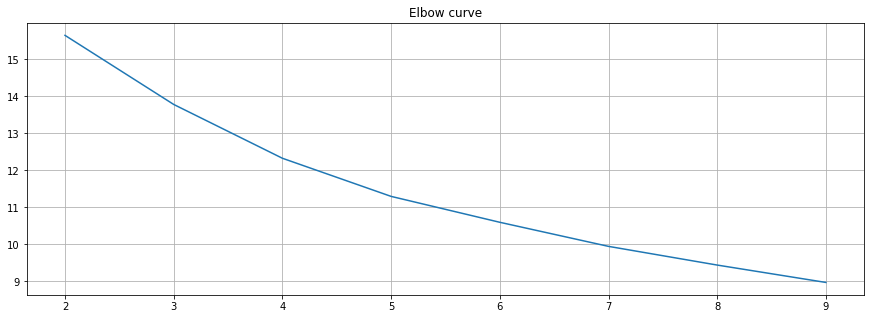

In [312]:
k_inertia = []
stations_grouped_clustering = stations_grouped.drop('Station', 1)

for k in range(2, 10):
    kmeans = KMeans(init = "k-means++", n_clusters=k, n_init = 12)
    kmeans.fit(stations_grouped_clustering)
    k_inertia.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), k_inertia)
plt.grid(True)
plt.title('Elbow curve')

### There is no distinct curve so the number of clusters will be five for simplicity

In [331]:
kclusters = 5

kmeans = KMeans(init = "k-means++", n_clusters=kclusters, n_init = 12).fit(stations_grouped_clustering)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:30]

array([2, 2, 0, 1, 1, 1, 0, 3, 2, 2, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 1, 1,
       0, 0, 4, 4, 2, 2, 4, 1])

In [334]:
# adding clustering labels
stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

stations_merged = stations

# merging stations_merged with station_venues_sorted to add latitude/longitude for each station
stations_merged = stations_merged.join(stations_venues_sorted.set_index('Station'), on='Station').dropna()

stations_merged.head()

,Station,Latitude,Longitude,Zone,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
1,Aldgate,51.514342,-0.075627,1,2.0,Art Gallery,Performing Arts Venue,Mini Golf,Tour Provider
2,Aldgate East,51.515082,-0.073001,1,2.0,Art Gallery,Performing Arts Venue,Tour Provider,Movie Theater
4,Angel,51.532968,-0.105581,1,0.0,Music Venue,Theater,Dance Studio,Movie Theater
6,Baker Street,51.523130,-0.156904,1,1.0,Museum,Art Gallery,Movie Theater,Theater
7,Bank,51.513347,-0.089000,1,1.0,Museum,Outdoor Sculpture,Art Gallery,Dance Studio


### Visualising the clusters on the map

In [335]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
plasma = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_merged['Latitude'], stations_merged['Longitude'], stations_merged['Station'], stations_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=plasma[int(cluster-1)],
        fill=True,
        fill_color=plasma[int(cluster-1)],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### The first cluster contains stations that have mainly Music Venues nearby

In [336]:
stations_merged.loc[stations_merged['Cluster Labels'] == 0, stations_merged.columns[[0] + list(range(5, stations_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
4,Angel,Music Venue,Theater,Dance Studio,Movie Theater
9,Barons Court,Music Venue,Movie Theater,Performing Arts Venue,Dance Studio
21,Bow Church,Music Venue,Performing Arts Venue,Art Gallery,Tour Provider
22,Bow Road,Music Venue,Performing Arts Venue,Art Gallery,Tour Provider
23,Brixton,Music Venue,Movie Theater,Jazz Club,Museum
25,Brondesbury,Music Venue,Art Gallery,Theater,Dance Studio
30,Camden Road,Rock Club,Music Venue,Art Gallery,Outdoor Sculpture
31,Camden Town,Music Venue,Rock Club,Museum,Comedy Club
35,Canonbury,Art Gallery,Music Venue,Theater,Comedy Club
36,Chalk Farm,Music Venue,Art Gallery,Rock Club,Outdoor Sculpture


### The second cluster contains stations that have mainly Museums nearby

In [337]:
stations_merged.loc[stations_merged['Cluster Labels'] == 1, stations_merged.columns[[0] + list(range(5, stations_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
6,Baker Street,Museum,Art Gallery,Movie Theater,Theater
7,Bank,Museum,Outdoor Sculpture,Art Gallery,Dance Studio
8,Barbican,Museum,Art Gallery,Performing Arts Venue,Concert Hall
32,Canada Water,Museum,Movie Theater,Theater,Performing Arts Venue
34,Cannon Street,Museum,Art Gallery,Memorial Site,Street Art
47,Cutty Sark for Maritime Greenwich,Museum,Art Gallery,Theater,Dance Studio
62,Euston,Museum,Art Gallery,Theater,Dance Studio
63,Euston Square,Museum,Art Gallery,Theater,Dance Studio
64,Farringdon,Museum,Movie Theater,Arts & Entertainment,Piano Bar
65,Fenchurch Street,Museum,Exhibit,Tour Provider,Performing Arts Venue


### The third cluster contains stations that have mainly Art Galleries nearby

In [338]:
stations_merged.loc[stations_merged['Cluster Labels'] == 2, stations_merged.columns[[0] + list(range(5, stations_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
1,Aldgate,Art Gallery,Performing Arts Venue,Mini Golf,Tour Provider
2,Aldgate East,Art Gallery,Performing Arts Venue,Tour Provider,Movie Theater
14,Bermondsey,Art Gallery,Performing Arts Venue,Go Kart Track,Indie Theater
15,Bethnal Green,Art Gallery,Comedy Club,Concert Hall,Museum
17,Blackfriars,Art Gallery,Museum,Theater,Exhibit
19,Bond Street,Art Gallery,Outdoor Sculpture,Concert Hall,Dance Studio
29,Cambridge Heath,Art Gallery,Music Venue,Museum,Concert Hall
41,Clapham High Street,Art Gallery,Concert Hall,Dance Studio,Indie Theater
44,Clapton,Art Gallery,Theater,Dance Studio,Music Venue
72,Goodge Street,Art Gallery,Museum,Exhibit,Music Venue


### The fourth cluster contains stations that have mainly Movie Theaters nearby

In [339]:
stations_merged.loc[stations_merged['Cluster Labels'] == 3, stations_merged.columns[[0] + list(range(5, stations_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
13,Belsize Park,Movie Theater,Performing Arts Venue,Music Venue,Museum
20,Borough,Performing Arts Venue,Theater,Music Venue,Movie Theater
48,Dalston Junction,Jazz Club,Movie Theater,Theater,Performing Arts Venue
49,Dalston Kingsland,Performing Arts Venue,Jazz Club,Movie Theater,Theater
83,Heron Quays,Movie Theater,Concert Hall,Performing Arts Venue,Museum
126,New Cross,Movie Theater,Performing Arts Venue,Art Gallery,Theater
151,Shadwell,Movie Theater,Arts & Entertainment,Street Art,Public Art
159,South Quay,Movie Theater,Concert Hall,Performing Arts Venue,Jazz Club
189,West Hampstead,Movie Theater,Opera House,Multiplex,Art Gallery
190,West Hampstead Thameslink,Movie Theater,Dance Studio,Opera House,Multiplex


### The final cluster contains stations that have mainly Theaters nearby

In [341]:
stations_merged.loc[stations_merged['Cluster Labels'] == 4, stations_merged.columns[[0] + list(range(5, stations_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
38,Charing Cross,Theater,Outdoor Sculpture,Art Gallery,Museum
39,City Thameslink,Outdoor Sculpture,Theater,Museum,Movie Theater
45,Covent Garden,Theater,Art Gallery,Comedy Club,Outdoor Sculpture
60,Embankment,Outdoor Sculpture,Theater,Art Gallery,Museum
61,Essex Road,Theater,Street Art,Music Venue,Museum
74,Great Portland Street,Outdoor Sculpture,Art Gallery,Theater,Music Venue
81,Hammersmith (Met.),Theater,Memorial Site,Street Art,Concert Hall
86,Holborn,Theater,Art Gallery,Dance Studio,Exhibit
94,Kennington,Art Gallery,Theater,Dance Studio,Museum
104,Kings Cross St. Pancras,Outdoor Sculpture,Art Gallery,Concert Hall,Museum


### The stations of London have successfully been clustered into five categories